<a href="https://colab.research.google.com/github/CodeInTheHorizon/predictive-customer-churn-xai/blob/main/03_Model_Interpretation_(XAI).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Goal**

- Explain why predictions happen
- Identify which features drive churn
- Translate ML output into business insights

In [1]:

import joblib
import shap
import pandas as pd
import matplotlib.pyplot as plt

shap.initjs()


In [2]:
ARTIFACTS_DIR = "/content/drive/MyDrive/ML_internship_projects/ConnectTel-churn-prediction/churn_artifacts"

best_model = joblib.load(f"{ARTIFACTS_DIR}/churn_pipeline.pkl")
X_test = joblib.load(f"{ARTIFACTS_DIR}/X_test.pkl")
y_test = joblib.load(f"{ARTIFACTS_DIR}/y_test.pkl")


In [3]:
preprocessor = best_model.named_steps["preprocessor"]
model = best_model.named_steps["model"]


In [4]:
X_test_transformed = preprocessor.transform(X_test)


In [5]:
preprocessor


ColumnTransformer(transformers=[('cat',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore'),
                                 Index(['Gender', 'Senior_Citizen', 'Partner', 'Dependents', 'Phone_Service',
       'Multiple_Lines', 'Internet_Service', 'Online_Security',
       'Online_Backup', 'Device_Protection', 'Tech_Support', 'Streaming_TV',
       'Streaming_Movies', 'Contract', 'Paperless_Billing', 'Payment_Method'],
      dtype='object')),
                                ('num', 'passthrough',
                                 Index(['Tenure_Months', 'Monthly_Charges', 'Total_Charges', 'CLTV',
       'TotalChargesPerTenure', 'ServiceCount', 'IsLongTermContract'],
      dtype='object'))])

In [6]:
categorical_cols = preprocessor.transformers_[0][2]
numerical_cols = preprocessor.transformers_[1][2]

print(categorical_cols)
print(numerical_cols)


Index(['Gender', 'Senior_Citizen', 'Partner', 'Dependents', 'Phone_Service',
       'Multiple_Lines', 'Internet_Service', 'Online_Security',
       'Online_Backup', 'Device_Protection', 'Tech_Support', 'Streaming_TV',
       'Streaming_Movies', 'Contract', 'Paperless_Billing', 'Payment_Method'],
      dtype='object')
Index(['Tenure_Months', 'Monthly_Charges', 'Total_Charges', 'CLTV',
       'TotalChargesPerTenure', 'ServiceCount', 'IsLongTermContract'],
      dtype='object')


In [7]:
ohe = preprocessor.named_transformers_["cat"]
cat_features = ohe.get_feature_names_out(categorical_cols)

all_feature_names = list(cat_features) + list(numerical_cols)

X_test_shap = pd.DataFrame(
    X_test_transformed,
    columns=all_feature_names
)


In [8]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_shap)


## Global Interpretation: What Drives Churn?

The SHAP summary plot below shows the overall importance of features in predicting
customer churn across the entire test dataset.


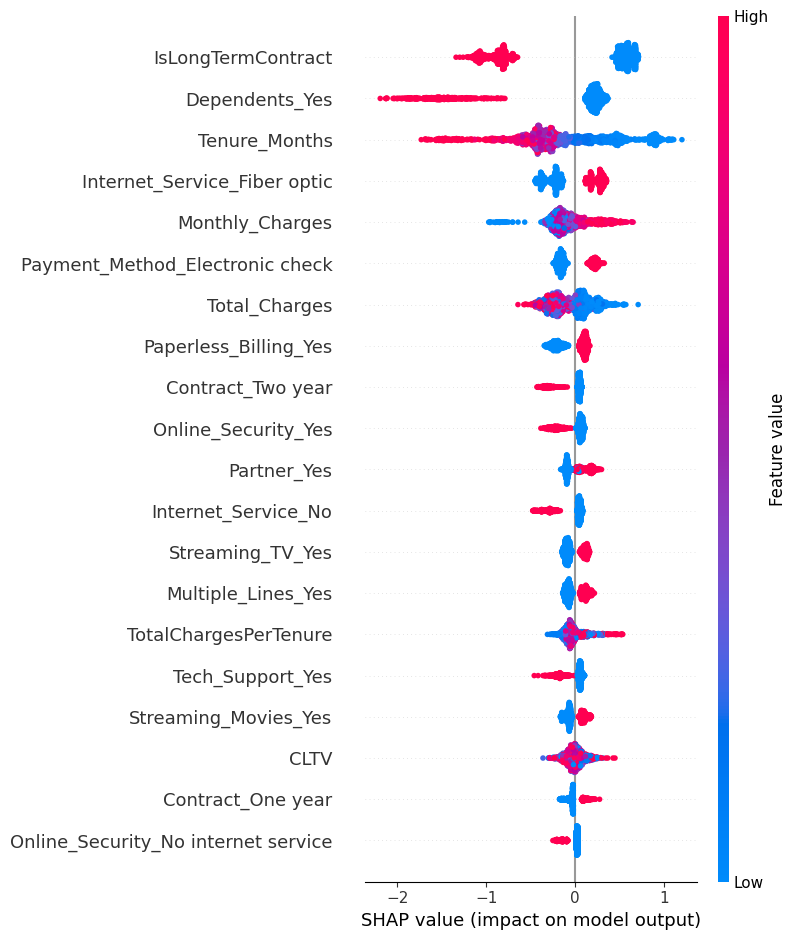

In [9]:
plt.figure()
shap.summary_plot(shap_values, X_test_shap, show=True)
plt.tight_layout()
plt.close()


## Feature-Level Interpretation (Direction & Impact)

The following plots show **how feature values influence churn risk**.
Each plot answers a different business question:

- Contract commitment vs churn
- Customer tenure vs churn
- Monthly charges vs churn


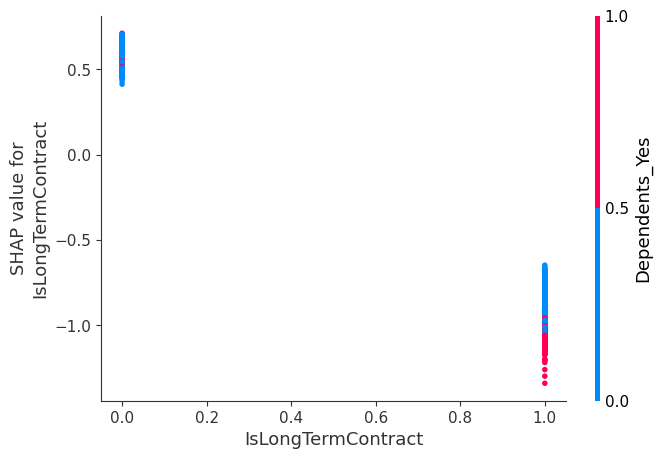

In [10]:
shap.dependence_plot(
    "IsLongTermContract",
    shap_values,
    X_test_shap,
    show=True
)


### Interpretation

- **Contract Commitment:** Customers without long-term contracts
  show consistently higher positive SHAP values, indicating increased churn risk.


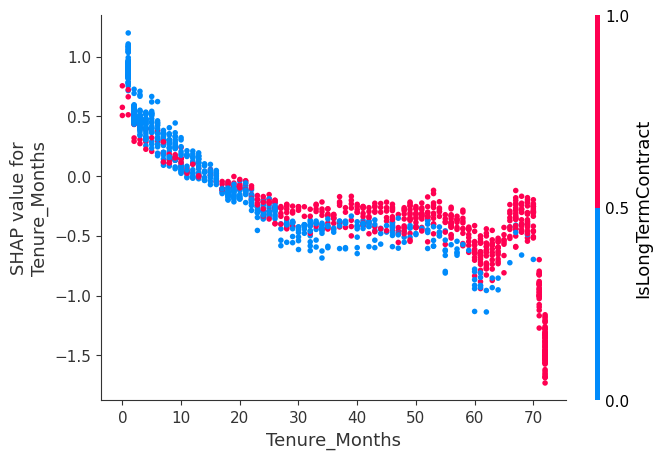

In [11]:
shap.dependence_plot(
    "Tenure_Months",
    shap_values,
    X_test_shap,
    show=True
)


### Interpretation
- **Tenure:** Churn risk decreases as customer tenure increases,
  reinforcing loyalty effects.



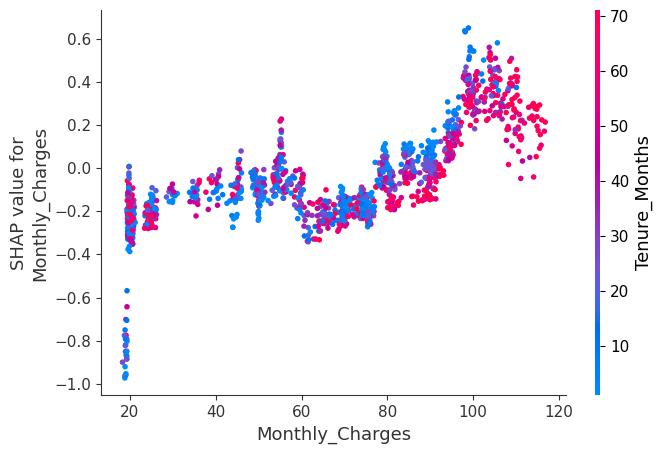

In [12]:
shap.dependence_plot(
    "Monthly_Charges",
    shap_values,
    X_test_shap,
    show=True
)


### Interpretation
- **Monthly Charges:** Higher charges increase churn risk, but the effect
  is weaker and more dispersed than contract type.

This confirms that **contract type is the dominant churn driver**, while
pricing acts as a secondary amplifier.


## Local Interpretation: Why Does This Customer Churn?

The waterfall plot below explains the churn prediction for a single customer
by showing how each feature contributes to the final decision.


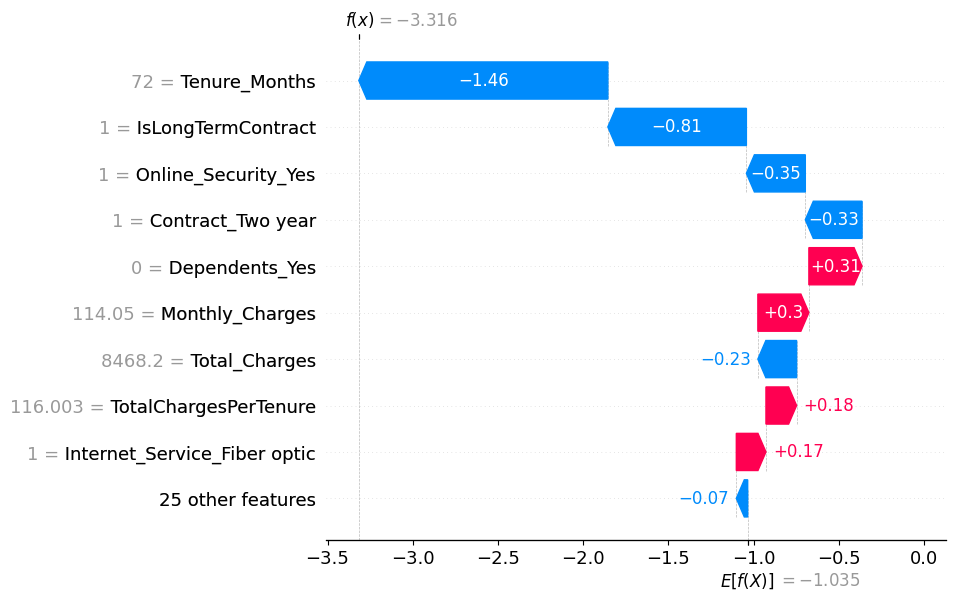

In [13]:
i = 0  # example customer index

shap.plots.waterfall(
    shap.Explanation(
        values=shap_values[i],
        base_values=explainer.expected_value,
        data=X_test_shap.iloc[i],
        feature_names=X_test_shap.columns
    )
)


## Phase 3: Model Interpretation Summary

- Long-term contracts and higher tenure strongly reduce churn probability
- Customers with dependents show higher retention
- High monthly charges and fiber optic service increase churn risk
- Add-on services such as online security and tech support reduce churn
- SHAP provides both global and individual-level explanations, making the model
  interpretable and business-ready




##Is the Month-to-Month contract the biggest driver of churn, or is it high Monthly Charges?

SHAP analysis shows that **contract type is a stronger driver of churn than monthly charges**.
Customers on **month-to-month contracts** exhibit significantly higher churn risk, as reflected
by the highest mean absolute SHAP values for contract-related features.

While **high monthly charges do contribute to churn**, their impact is **secondary** compared
to the structural effect of contract commitment.

**Conclusion:**  
*Month-to-month contracts are the primary driver of churn, while high monthly charges act as a
secondary amplifier rather than the dominant cause.*
